<center><h1>Wong_Jonathan_HW4</h1></center>
<br>
<br>

Name: Jonathan Wong
<br>
Github Username: jonathanwong150
<br>
USC ID: 9171949586

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [188]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import cycle

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.utils import resample
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import label_binarize

from statsmodels.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

Get the AReM Data Set

In [90]:
# Initialize empty lists to hold test and train data
testData = []
trainData = []

# List of folders in the dataset
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']

# Define the path to the dataset
dataPath = "../data/AReM/"

### (b) Splitting Data

In [91]:
# Loop through each folder to read the CSV files
for folder in folders:
    folderPath = os.path.join(dataPath, folder)
    files = os.listdir(folderPath)
    
    # Sort files to ensure they are in numerical order
    files.sort()
    
    # Decide which files to use for training and testing based on the task description
    if folder in ['bending1', 'bending2']:
        testFiles = files[:2]
        trainFiles = files[2:]
    else:
        testFiles = files[:3]
        trainFiles = files[3:]
    
    # Read test and train files and append them to respective lists
    for file in testFiles:
        filePath = os.path.join(folderPath, file)
        df = pd.read_csv(filePath, skiprows=4)
        df['label'] = folder
        testData.append(df)
    
    for file in trainFiles:
        filePath = os.path.join(folderPath, file)
        df = pd.read_csv(filePath, skiprows=4)
        df['label'] = folder
        trainData.append(df)

# Convert lists to pandas DataFrames
testData = pd.concat(testData, keys=range(len(testData)))
trainData = pd.concat(trainData, keys=range(len(trainData)))

### (c) Feature Extraction

In [92]:
# Initialize empty lists to hold feature vectors for test and train data
testFeatures = []
trainFeatures = []

# List of columns that represent time series in the dataset
seriesCols = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# Function to calculate time-domain features for each instance
def calculateFeatures(data):
    features = []
    for column in seriesCols:
        minVal = np.min(data[column])
        maxVal = np.max(data[column])
        meanVal = np.mean(data[column])
        medianVal = np.median(data[column])
        std = np.std(data[column])
        firstQuart = np.percentile(data[column], 25)
        thirdQuart = np.percentile(data[column], 75)
        
        features.extend([minVal, maxVal, meanVal, medianVal, std, firstQuart, thirdQuart])
    return features

# Loop through each instance in test and train data to calculate features
for i in range(len(testData.groupby(level=0))):
    instance = testData.loc[i]
    features = calculateFeatures(instance)
    features.append(instance['label'].iloc[0])
    testFeatures.append(features)

for i in range(len(trainData.groupby(level=0))):
    instance = trainData.loc[i]
    features = calculateFeatures(instance)
    features.append(instance['label'].iloc[0])
    trainFeatures.append(features)

# Convert feature lists to DataFrames and add column names
featureCols = [f"{feature}{seriesCols[i]}" for i in range(6) for feature in ['min_', 'max_', 'mean_', 'median_', 'std_dev_', '1st_quart_', '3rd_quart_']]
featureCols.append('label')

testFeatDf = pd.DataFrame(testFeatures, columns=featureCols)
trainFeatDf = pd.DataFrame(trainFeatures, columns=featureCols)

# Output the new dataset with extracted features
print("Test Features DataFrame:")
print(testFeatDf.head())

print("\nTrain Features DataFrame:")
print(trainFeatDf.head())

Test Features DataFrame:
   min_avg_rss12  max_avg_rss12  mean_avg_rss12  median_avg_rss12  \
0          37.25          45.00       40.624792             40.50   
1          38.00          45.67       42.812812             42.50   
2          12.75          51.00       24.562958             24.25   
3           0.00          42.75       27.464604             28.00   
4          24.25          45.00       37.177042             36.25   

   std_dev_avg_rss12  1st_quart_avg_rss12  3rd_quart_avg_rss12  min_var_rss12  \
0           1.475428              39.2500                42.00            0.0   
1           1.434054              42.0000                43.67            0.0   
2           3.733619              23.1875                26.50            0.0   
3           3.579847              25.5000                30.00            0.0   
4           3.577569              34.5000                40.25            0.0   

   max_var_rss12  mean_var_rss12  ...  1st_quart_avg_rss23  \
0          

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

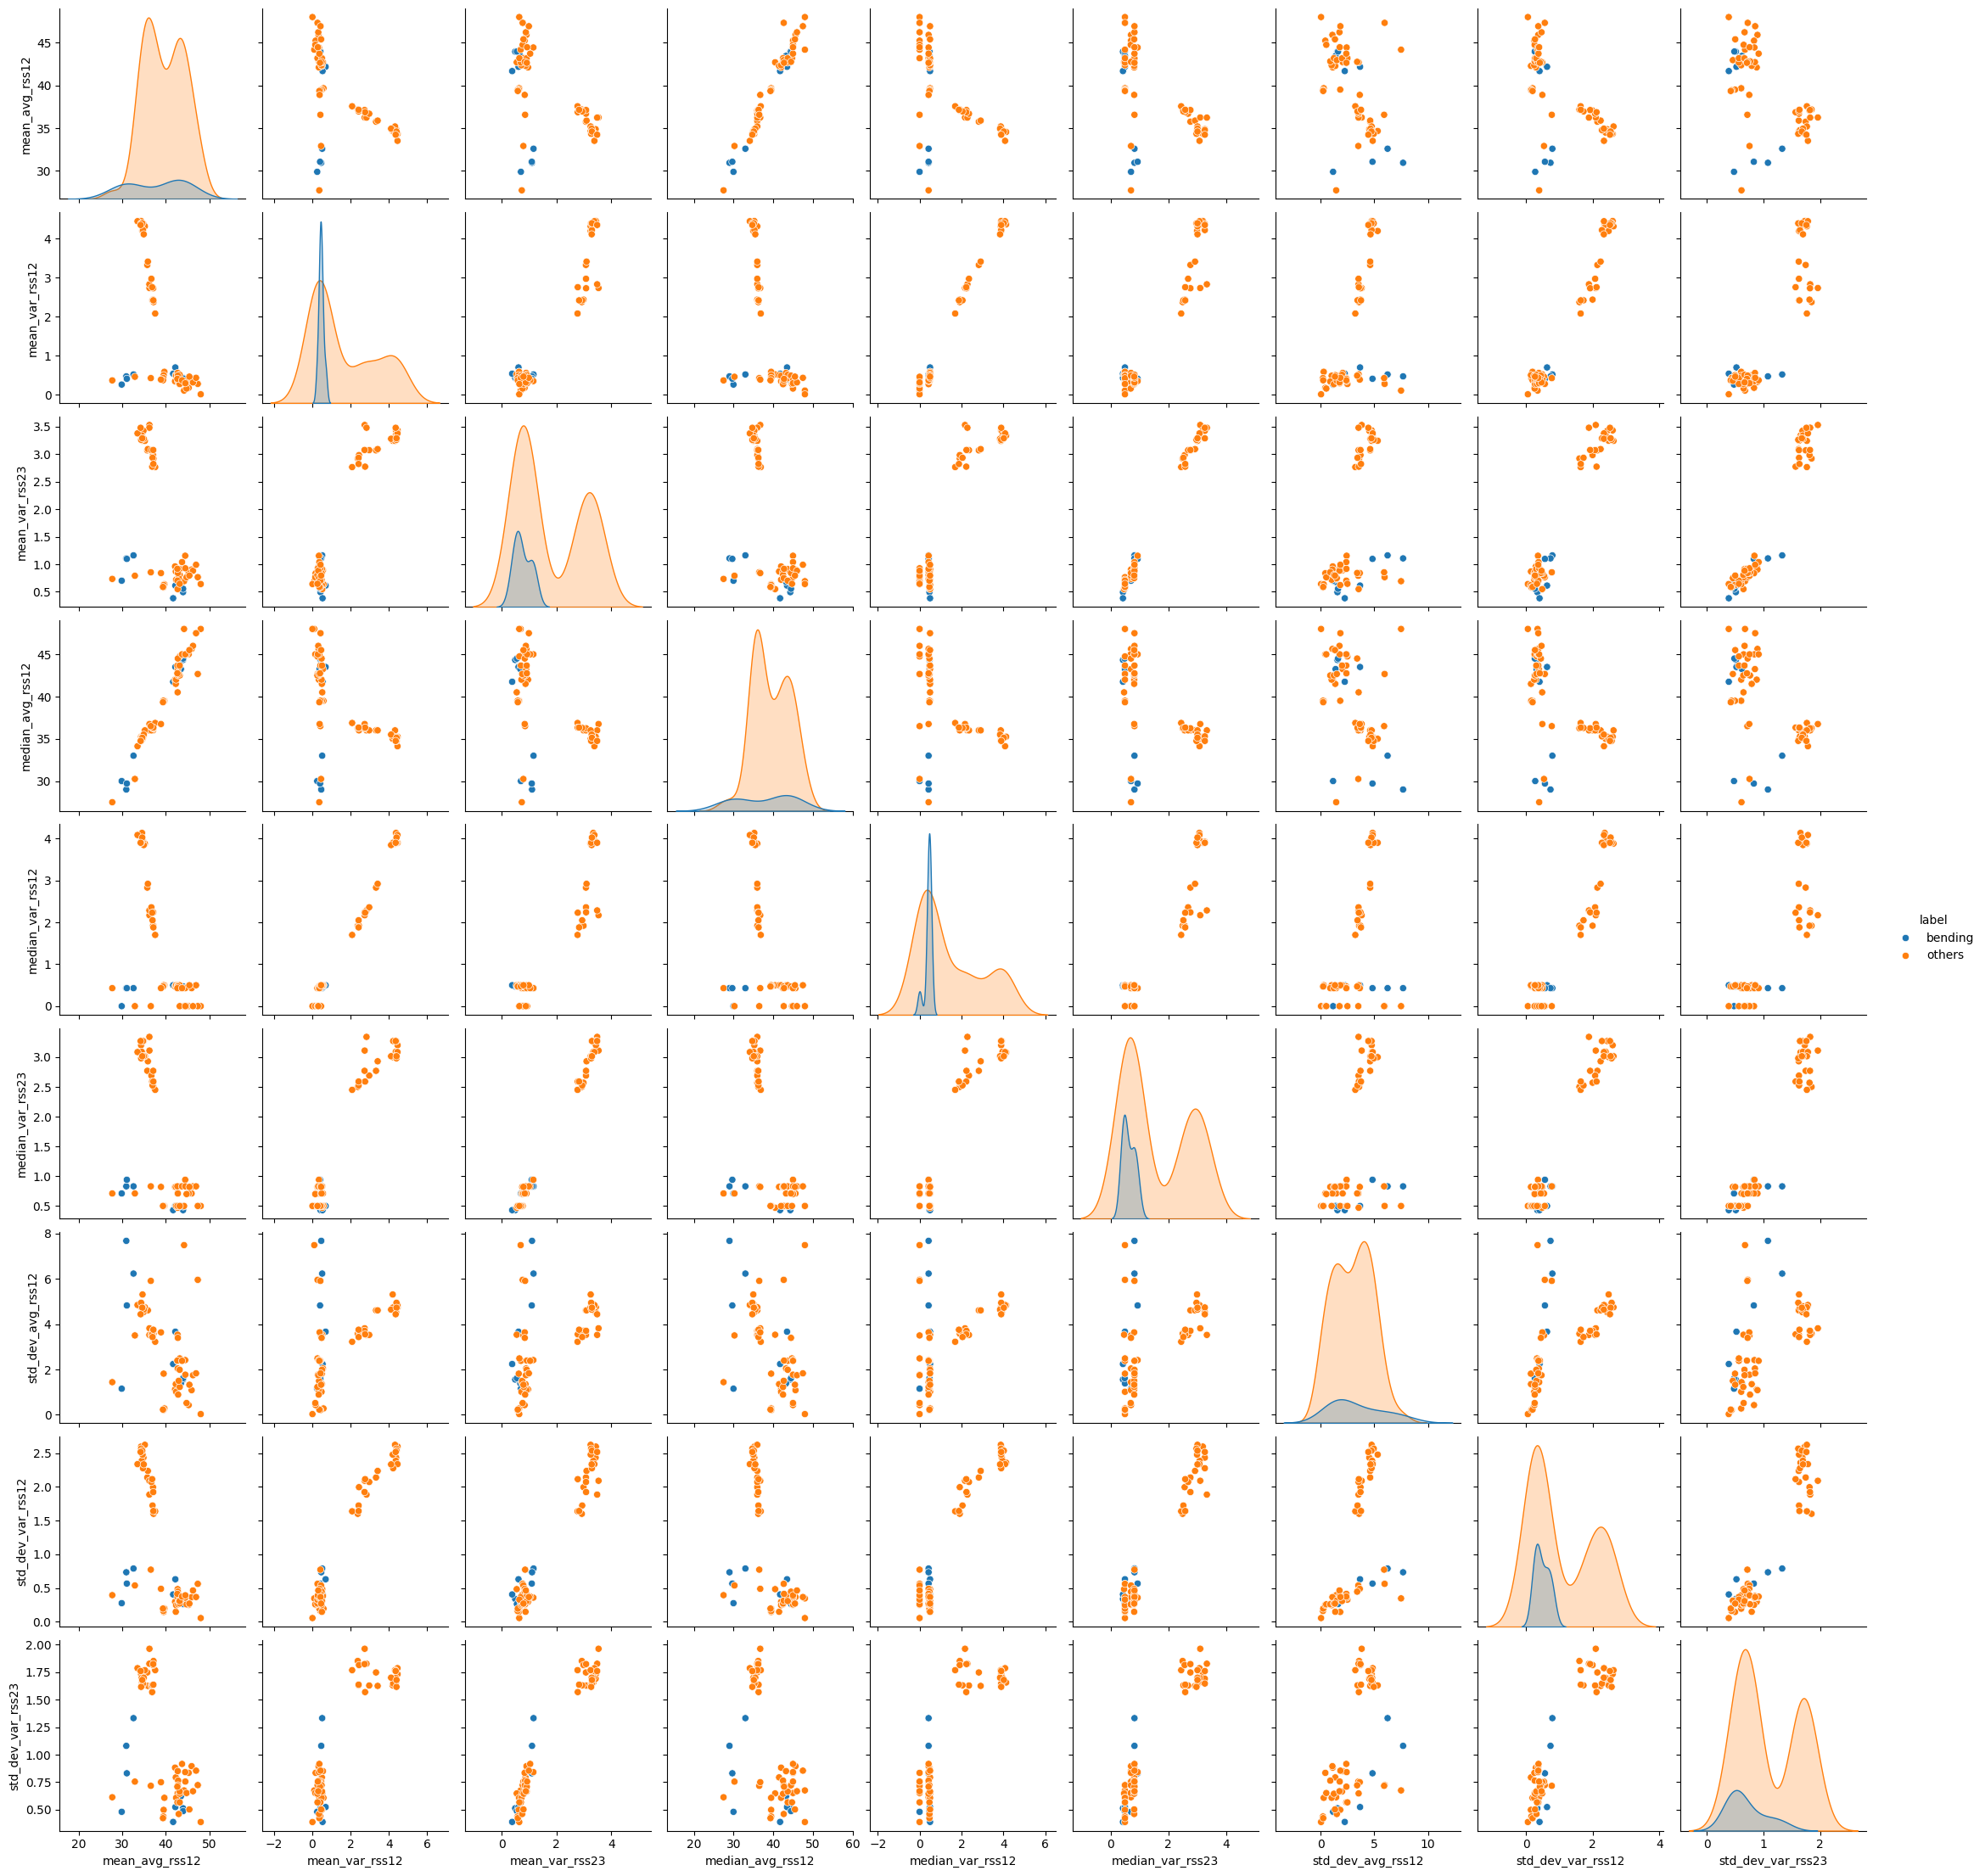

In [93]:
# Extract only the columns that are needed for the pairplot
selectedCols = ['mean_avg_rss12', 'mean_var_rss12', 'mean_var_rss23', 'median_avg_rss12', 'median_var_rss12', 'median_var_rss23', 'std_dev_avg_rss12', 'std_dev_var_rss12', 'std_dev_var_rss23', 'label']
trainSelected = trainFeatDf[selectedCols]

# 'bending' if the activity is bending1 or bending2, 'others' otherwise
trainSelected['label'] = trainSelected['label'].apply(lambda x: 'bending' if 'bending' in x else 'others')

# Create pairplot
sns.pairplot(trainSelected, hue='label', vars=['mean_avg_rss12', 'mean_var_rss12', 'mean_var_rss23', 'median_avg_rss12', 'median_var_rss12', 'median_var_rss23', 'std_dev_avg_rss12', 'std_dev_var_rss12', 'std_dev_var_rss23'])
plt.show()

#### ii. Splitted Plots

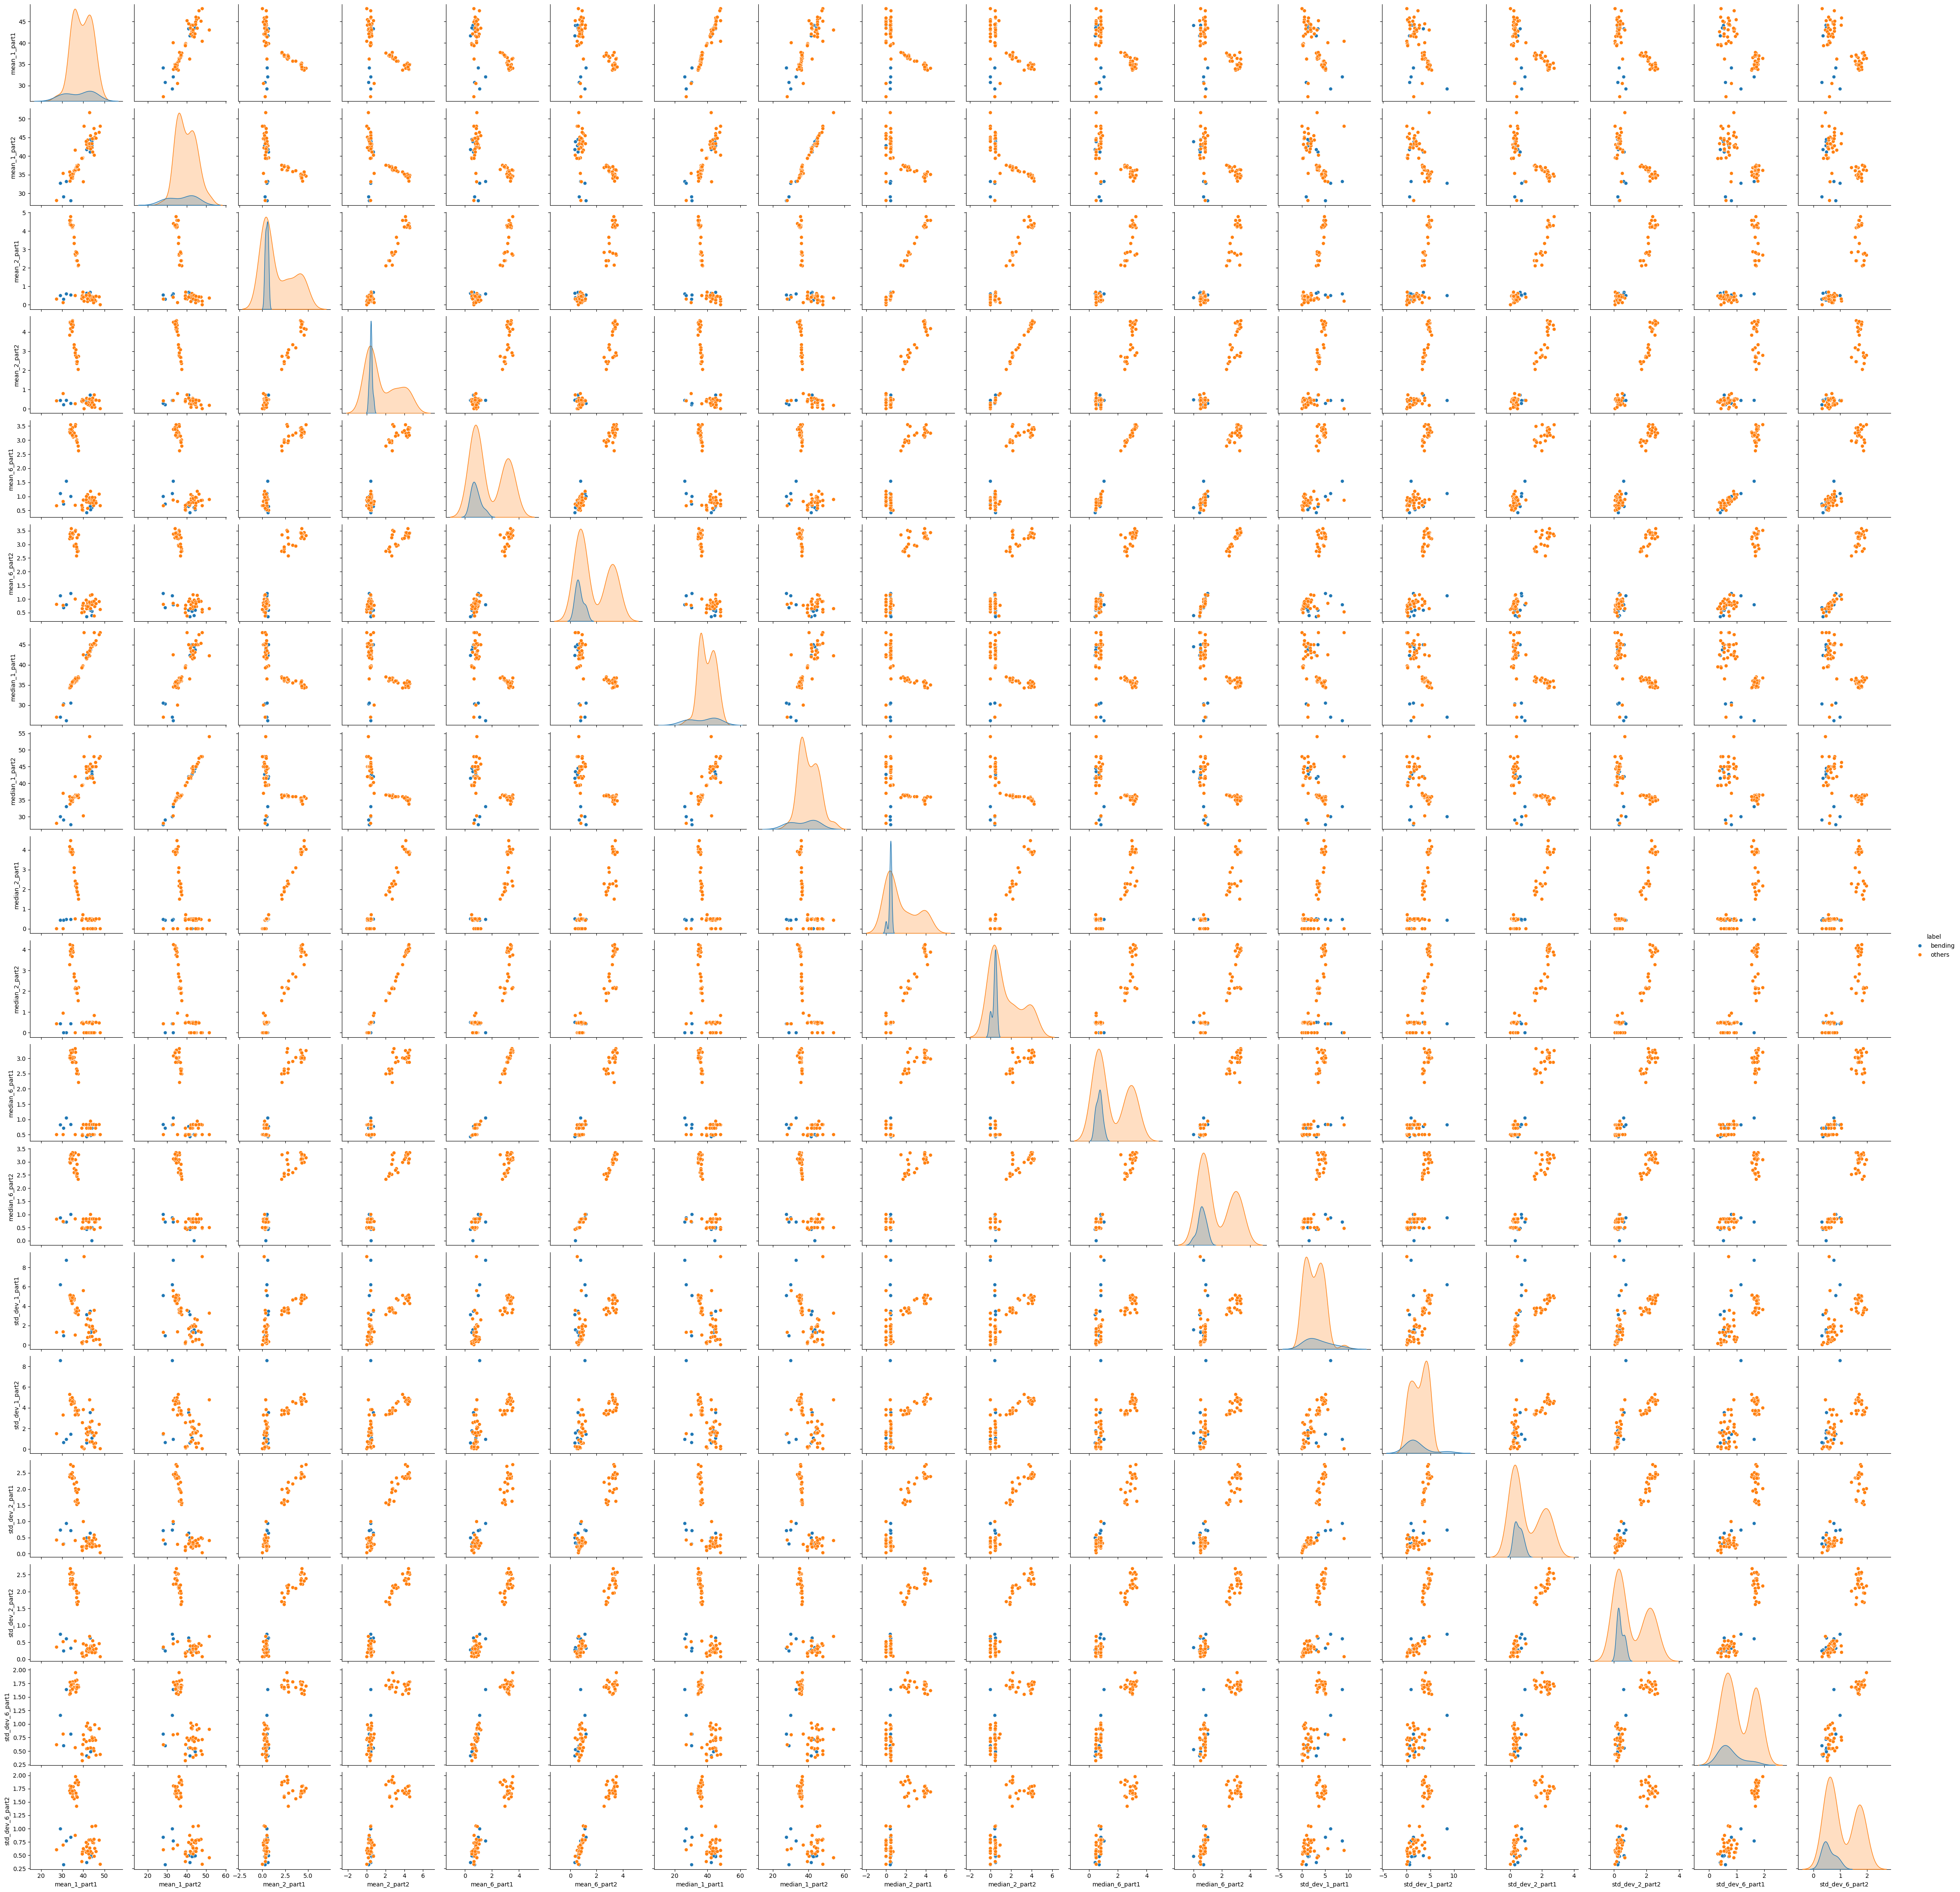

In [94]:
newTrainFeats = []

# Loop through each instance in the training data to calculate features
for i in range(len(trainData.groupby(level=0))):
    instance = trainData.loc[i]
    features = []
    
    # Loop through each time series column
    for column in seriesCols:
        midpoint = len(instance) // 2
        firstHalf = instance[column][:midpoint]
        secondHalf = instance[column][midpoint:]
        
        # Calculate features for both parts and extend them to the features list
        for part in [firstHalf, secondHalf]:
            minVal = np.min(part)
            maxVal = np.max(part)
            meanVal = np.mean(part)
            medianVal = np.median(part)
            std = np.std(part)
            firstQuart = np.percentile(part, 25)
            thirdQuart = np.percentile(part, 75)
            
            features.extend([minVal, maxVal, meanVal, medianVal, std, firstQuart, thirdQuart])
    
    features.append(instance['label'].iloc[0])
    newTrainFeats.append(features)

newColFeats = [f"{feature}{i+1}_part{j+1}" for i in range(6) for j in range(2) for feature in ['min_', 'max_', 'mean_', 'median_', 'std_dev_', '1st_quart_', '3rd_quart_']]
newColFeats.append('label')

newTrainFeatDf = pd.DataFrame(newTrainFeats, columns=newColFeats)
newTrainFeatDf['label'] = newTrainFeatDf['label'].apply(lambda x: 'bending' if 'bending' in x else 'others')

newSelectedCols = ['mean_1_part1', 'mean_1_part2', 'mean_2_part1', 'mean_2_part2', 'mean_6_part1', 'mean_6_part2',
                        'median_1_part1', 'median_1_part2', 'median_2_part1', 'median_2_part2', 'median_6_part1', 'median_6_part2',
                        'std_dev_1_part1', 'std_dev_1_part2', 'std_dev_2_part1', 'std_dev_2_part2', 'std_dev_6_part1', 'std_dev_6_part2',
                        'label']

newSelectedTrain = newTrainFeatDf[newSelectedCols]

sns.pairplot(newSelectedTrain, hue='label')
plt.show()


#### iii. Time Series Segments

In [125]:
bestL = 0
bestP = 0
bestAccuracy = -1

for L in range(1, 21):  
    allFeats = []

    # Calculate features for each time series by dividing it into L segments
    for i in range(len(trainData.groupby(level=0))):
        instance = trainData.loc[i]
        features = []
        for col in seriesCols:
            segmentedSeries = np.array_split(instance[col], L)
            for segment in segmentedSeries:
                features.extend([np.mean(segment), np.median(segment), np.std(segment)])
        
        allFeats.append(features + [instance['label'].iloc[0]])

    # Create DataFrame from feature lists
    featureCols = [f"feature_{i+1}" for i in range(len(allFeats[0]) - 1)] + ['label']
    featureDf = pd.DataFrame(allFeats, columns=featureCols)

    X = featureDf.drop('label', axis=1)
    y = featureDf['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)
    
    # Recursive feature elimination with cross-validation
    estimator = LogisticRegression()
    selector = RFECV(estimator, step=1, cv=StratifiedKFold(5))
    selector = selector.fit(X, y)
    xPruned = selector.transform(X)

    # Fit logistic regression model and get p-values
    xConst = sm.add_constant(xPruned)  
    try:
        model = sm.Logit(y, xConst)
        result = model.fit(disp=0)
    except np.linalg.LinAlgError:
        continue
    
    pVals = result.pvalues
    sigVarsInd = np.where(pVals < 0.05)[0]

    if len(sigVarsInd) == 0:  # Skip if no significant features
        continue

    xSig = xConst[:, sigVarsInd]

    # Stratified 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5)
    scores = []
    
    for trainInd, testInd in skf.split(xSig, y):
        xTrain, xTest = xSig[trainInd], xSig[testInd]
        yTrain, yTest = y.iloc[trainInd], y.iloc[testInd]
        
        estimator.fit(xTrain, yTrain)
        yPred = estimator.predict(xTest)
        scores.append(accuracy_score(yTest, yPred))
    
    avgScore = np.mean(scores)
    
    if avgScore > bestAccuracy:
        bestAccuracy = avgScore
        bestL = L
        bestP = xSig.shape[1]

print(f"The best l is {bestL}, with best p as {bestP} and the best accuracy as {bestAccuracy}")


The best l is 20, with best p as 2 and the best accuracy as 0.9714285714285715


Incorrect method: Fitting the logistic regression model and selecting features (through recursive feature elimination) using the entire dataset, and then applying cross-validation.

Correct method: Break the dataset into folds and for each fold: Perform feature selection only on the training portion, fit the model on the training portion, test the model on the validation portion.

#### iv. Confusion Matrix

Confusion Matrix:
 [[48  0]
 [ 1  7]]


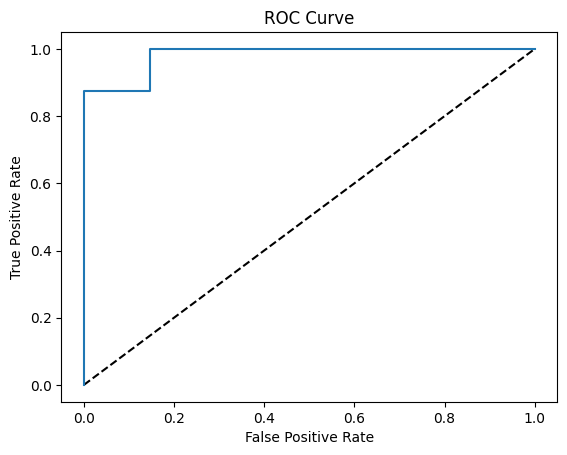

AUC Score: 0.9817708333333334
Optimization terminated successfully.
         Current function value: 0.088353
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                   56
Model:                          Logit   Df Residuals:                       54
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                  0.7846
Time:                        21:34:17   Log-Likelihood:                -4.9478
converged:                       True   LL-Null:                       -22.967
Covariance Type:            nonrobust   LLR p-value:                 1.936e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0875      9.473     -2.226      0.026     -39.653      -2.52

In [153]:
xTrain = xTrain[:, np.any(xTrain != xTrain[0, :], axis=0)]

model = LogisticRegression(max_iter=100)
model.fit(xTrain, yTrain)

yTrainPred = model.predict(xTrain)
cm = confusion_matrix(yTrain, yTrainPred)
print("Confusion Matrix:\n", cm)

yTrainProb = model.predict_proba(xTrain)[:, 1]
fpr, tpr, thresholds = roc_curve(yTrain, yTrainProb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

aucScore = roc_auc_score(yTrain, yTrainProb)
print(f"AUC Score: {aucScore}")

xConst = sm.add_constant(xTrain)
smModel = sm.Logit(yTrain, xConst)

try:
    result = smModel.fit()
    print(result.summary())
except np.linalg.LinAlgError:
    print("")


#### v. Test Classifier

In [137]:
xTest = xTest[:, np.any(xTest != xTest[0, :], axis=0)]

# Use trained model for prediction on test set
yTestPred = model.predict(xTest)
testCm = confusion_matrix(yTest, yTestPred)
print("Test Set Confusion Matrix:\n", testCm)

testAccuracy = accuracy_score(yTest, yTestPred)

print(f"Test Set Accuracy: {testAccuracy}")
print(f"Cross-Validation Accuracy: {bestAccuracy}")

if testAccuracy > bestAccuracy:
    print("The model performs better on the test set.")
elif testAccuracy < bestAccuracy:
    print("The model performs better during cross-validation.")
else:
    print("The model performs equally well on both the test set and during cross-validation.")

Test Set Confusion Matrix:
 [[12  0]
 [ 0  1]]
Test Set Accuracy: 1.0
Cross-Validation Accuracy: 0.9714285714285715
The model performs better on the test set.


#### vi. Separation

The classes do not seem to be well separated. Therefore, some folds might not get any samples from the minority class. So, to solve this problem, Stratified K-fold Cross Validation has been used to take care of class imbalance and reduce instability. 

#### vii. Imbalance

label
0.0    47
1.0    47
Name: count, dtype: int64
Test Set Confusion Matrix: [[12  0]
 [ 0  1]]
ROC AUC: 1.0


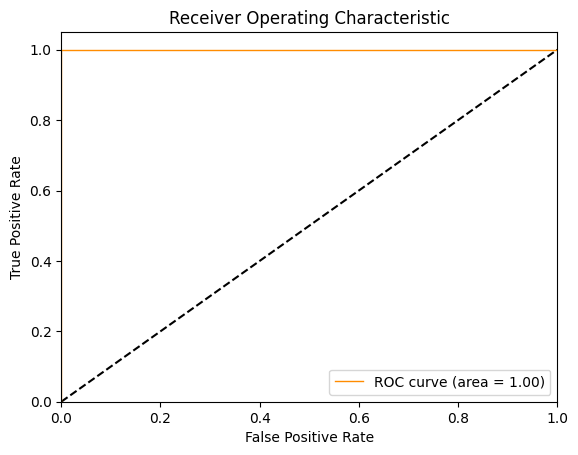

In [154]:
# Separate majority and minority classes
df = pd.DataFrame(xTrain)
df['label'] = yTrain
majority = df[df.label==0]
minority = df[df.label==1]

# Upsample minority class
minorUpsample = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=123)

# Combine majority class with upsampled minority class
upsampleDf = pd.concat([majority, minorUpsample])

print(upsampleDf.label.value_counts())

xTrainBalanced = upsampleDf.drop('label', axis=1)
yTrainBalanced = upsampleDf.label

# Train logistic regression on balanced data
modelBalanced = LogisticRegression(max_iter=100)
modelBalanced.fit(xTrainBalanced, yTrainBalanced)

yTestPred = modelBalanced.predict(xTest)
testCm = confusion_matrix(yTest, yTestPred)
print("Test Set Confusion Matrix:\n", testCm)

yTestProb = modelBalanced.predict_proba(xTest)[:, 1]
fpr, tpr, thresholds = roc_curve(yTest, yTestProb)
rocAuc = roc_auc_score(yTest, yTestProb)

print(f"ROC AUC: {rocAuc}")

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % rocAuc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Yes, the classes are unbalanced since we have far more samples in the training set compared to the test set.

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [169]:
bestL = 0
bestC = 0
bestAccuracy = -1
yLabels = []

for L in range(1, 21):  
    allFeats = []
    yLabels.clear()

    for i in range(len(trainData.groupby(level=0))):
        instance = trainData.loc[i]
        features = []
        for col in seriesCols:
            segmentedSeries = np.array_split(instance[col], L)
            for segment in segmentedSeries:
                features.extend([np.mean(segment), np.median(segment), np.std(segment)])

        allFeats.append(features)
        yLabels.append(instance['label'].iloc[0])  

    # Create Dataframe from feature lists
    featureCols = [f"feature_{i+1}" for i in range(len(allFeats[0]))]
    featureDf = pd.DataFrame(allFeats, columns=featureCols)

    X = featureDf
    y = pd.Series(yLabels).apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)  # Replace as appropriate

    # Stratified 5-fold Cross-validation for logistic regression with L1 penalty
    estimator = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', solver='saga', max_iter=500)
    estimator.fit(X, y)

    avgScore = np.mean(estimator.scores_[1])
    currBestC = estimator.C_[0]

    if avgScore > bestAccuracy:
        bestAccuracy = avgScore
        bestL = L
        bestC = currBestC

print(f"The best L is {bestL}, with best C as {bestC} and the best accuracy as {bestAccuracy}")

The best L is 6, with best C as 0.3593813663804626 and the best accuracy as 0.9282417582417583


#### ii. Comparison

The L1 penalised Logistic Regression model is easier to implement because we just have to add one regularization parameter. Hence, L1-penalised Logistic Regression model performs worse for this dataset as the best accuracy is lower than the one we found previously.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [182]:
# I couldn't figure out my errors :(

def extractFeatures(data, L, cols):
    allFeats = []
    for i in range(len(data.groupby(level=0))):
        instance = data.loc[i]
        features = []
        for col in cols:
            segmentedSeries = np.array_split(instance[col], L)
            for segment in segmentedSeries:
                features.extend([np.mean(segment), np.median(segment), np.std(segment)])
        allFeats.append(features)
    return allFeats

bestL = 0
bestAccuracy = -1

for L in range(1, 21):  
    X = extractFeatures(trainData, L, seriesCols)
    y = yLabels 

    estimator = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', solver='saga', max_iter=500, multi_class='multinomial')
    estimator.fit(X, y)
    avgScore = np.mean(list(estimator.scores_.values())[0])

    if avgScore > bestAccuracy:
        bestAccuracy = avgScore
        bestL = L

print(f"The best L is {bestL} and the best accuracy is {bestAccuracy}")

# Extract features for the best L and fit  model
L = bestL
X = extractFeatures(trainData, L, seriesCols)
y = yLabels
xTest = extractFeatures(testData, L, seriesCols)
yTest = yLabels

estimator = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', solver='saga', max_iter=500, multi_class='multinomial')
estimator.fit(X, y)

# Test the model on xTest
yPred = estimator.predict(xTest)
testError = 1 - accuracy_score(yTest, yPred)
print(f"Test error: {testError}")

confMatrix = confusion_matrix(yTest, yPred)
print(f"Confusion Matrix: \n{confMatrix}")

# ROC and AUC for multiclass
yTestBin = label_binarize(yTest, classes=['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'])
yScore = estimator.decision_function(xTest)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
rocAuc = dict()
nClasses = yTestBin.shape[1]
for i in range(nClasses):
    fpr[i], tpr[i], _ = roc_curve(yTestBin[:, i], yScore[:, i])
    rocAuc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
for i, label in enumerate(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label} (area = {rocAuc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

The best L is 1 and the best accuracy is 0.602087912087912


ValueError: Found input variables with inconsistent numbers of samples: [69, 19]

#### ii. Naive Bayes

In [187]:
bestGaussL = 0
bestAccuracyGauss = -1
bestMultiL = 0
bestAccuracyMulti = -1

for L in range(1, 21):
    X = extractFeatures(trainData, L, seriesCols)
    y = yLabels
    gnb = GaussianNB()
    gnb.fit(X, y)
    score = gnb.score(X, y)
    
    if score > bestAccuracyGauss:
        bestAccuracyGauss = score
        bestGaussL = L

print(f"For GaussianNB, the best L is {bestGaussL} and the best accuracy is {bestAccuracyGauss}")

for L in range(1, 21):
    X = extractFeatures(trainData, L, seriesCols)
    y = yLabels
    mnb = MultinomialNB()
    mnb.fit(X, y)
    score = mnb.score(X, y)
    
    if score > bestAccuracyMulti:
        bestAccuracyMulti = score
        bestMultiL = L

print(f"For MultinomialNB, the best L is {bestMultiL} and the best accuracy is {bestAccuracyMulti}")

# Testing with best L for Gaussian
L = bestGaussL
X = extractFeatures(trainData, L, seriesCols)
y = yLabels
xTest = extractFeatures(testData, L, seriesCols)
yTest = yLabels

gnb = GaussianNB()
gnb.fit(X, y)
yPredGauss = gnb.predict(xTest)
testErrorGauss = 1 - accuracy_score(yTest, yPredGauss)
print(f"GaussianNB Test error: {testErrorGauss}")

# Testing with best L for Multinomial
L = bestMultiL
X = extractFeatures(trainData, L, seriesCols)
y = yLabels
xTest = extractFeatures(testData, L, seriesCols)
yTest = yLabels

mnb = MultinomialNB()
mnb.fit(X, y)
yPredMulti = mnb.predict(xTest)
testErrorMulti = 1 - accuracy_score(yTest, yPredMulti)
print(f"MultinomialNB Test error: {testErrorMulti}")

confMatrixGauss = confusion_matrix(yTest, yPredGauss)
confMatrixMulti = confusion_matrix(yTest, yPredMulti)
print(f"Confusion Matrix for GaussianNB: \n{confMatrixGauss}")
print(f"Confusion Matrix for MultinomialNB: \n{confMatrixMulti}")

For GaussianNB, the best L is 2 and the best accuracy is 1.0
For MultinomialNB, the best L is 10 and the best accuracy is 0.9420289855072463


ValueError: Found input variables with inconsistent numbers of samples: [69, 19]

#### ii. Comparison

Multinomial Naive Bayes Classifier is better for multi-class classification because the best accuracy is higher than that of the previous.

## 3. ISLR 4.8.3

In QDA, we're trying to classify an observation into one of K classes. The main idea is that each class has its own normal distribution with a unique mean and variance.

In the one-feature case, the Bayes classifier aims to assign an observation x to the class k that maximizes a particular expression, which, for a one-dimensional Gaussian distribution, involves terms like (x−μk)^2 and σk^2.

If we take the logarithm to simplify that expression, we still have a quadratic term. Thus, the Bayes classifier is quadratic.

## 4. ISLR 4.8.7

We can use the Bayes' theorem assuming that X follows a normal distribution for both classes. First, we can calculate f(X=4∣Yes) = .044 using the density function for a normal distribution. Next, we find that f(X=4∣No) = .051. Now, using Bayes' theorem, the probability that a company with X=4 will issue a dividend is .775.

Note: I couldn't figure out a way to get my calculation in here as I don't know LaTeX sorry

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9